# Convolutional Neural Networks 
### Home Security Application
---

## Step 0: Import Datasets
In the code cell below, we save the file paths in numpy arrays `alfian_files` and `yusuf files`.

In [20]:
import numpy as np
from glob import glob

# Load filenames for users: alfian and yusuf
alfian_files = np.array(glob("../dataset/alfian/*"))
yusuf_files = np.array(glob("../dataset/yusuf/*"))

# Print number of images in each dataset
print('There are %d total Alfian images.' % len(alfian_files))
print('There are %d total Yusuf images.' % len(yusuf_files))

There are 243 total Alfian images.
There are 352 total Yusuf images.


## Step 1: Detect Face
In this secton, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `detector_architectures` directory.

Number of faces detected: 1


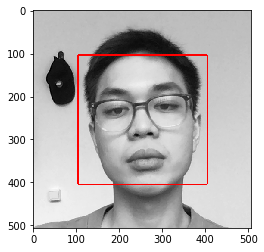

In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('../detector_architectures/haarcascade_frontalface_default.xml')

# Load grayscale image from the dataset
gray = cv2.imread(alfian_files[0])

# Find face in the image
faces = face_cascade.detectMultiScale(gray)

# Print number of faces detected in the image
print('Number of faces detected:', len(faces))

# Get bounding box for each detected face
for (x,y,w,h) in faces:
    cv2.rectangle(gray, (x,y), (x+w,y+h), (255,0,0),2)
    
# Display the image, along with bounding box
plt.imshow(gray)
plt.show()

It is a standard procedure to convert image to grayscale before using any face detectors. In our case, the dataset contains grayscale image and thus conversion is not required.

If the dataset contains color images, below is the procedure to convert the image into grayscale:
```python
# Load (BGR) image
img = cv2.imread(alfian_files[1])
# Convert BGR image to grayscale
gray = cv2.cvtcolor(img, cv2.COLOR_BGR2GRAY)
```

### Check the quality of dataset
To quickly check the quality of our dataset, we would like to scan all of the images in the datasets and check the percentage of the detected human faces from each dataset folder.

In [21]:
# Write a human face detector
def face_detector(img_path, kind='color'):
    img = cv2.imread(img_path)
    if kind == 'color':
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(img_gray)
        return len(faces) > 0
    if kind == 'gray':
        faces = face_cascade.detectMultiScale(img)
        return len(faces) > 0


members = {'alfian': alfian_files,
           'yusuf': yusuf_files}
counts = {'alfian': 0,
          'yusuf': 0}

for member in members:
    n_data = len(members[member])
    for i in range(n_data):
        if face_detector(members[member][i]) == True:
            counts[member] += 1
    percent = 100 * counts[member] / n_data
    print('Detected {} faces in {}_files: {}%'.format(member, member, percent))

Detected alfian faces in alfian_files: 97.11934156378601%
Detected yusuf faces in yusuf_files: 99.7159090909091%


## Step 2: Face Detection with Pretrained Model

In this part, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to classify faces in our dataset.

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [29]:
import torch
import torchvision.models as models

# Define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Move model to GPU if cuda is available
if use_cuda:
    VGG16.cuda()

## Specify Data Loaders for Our Dataset

In [71]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Load and transform data using ImageFolder
size= 224

transform = transforms.Compose([transforms.RandomResizedCrop(size),
                                transforms.RandomRotation(degrees=15),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                               ])

# Load image and put label on them based on the folder name: 1->alfian, 2->yusuf
dataset = datasets.ImageFolder('../dataset/', transform=transform)

# Split dataset into training, validation, and test
def get_subset(indices, start, end):
    return indices[start : start + end]


TRAIN_PCT, VALIDATION_PCT = 0.6, 0.2  # rest will go for test
train_count = int(len(dataset) * TRAIN_PCT)
validation_count = int(len(dataset) * VALIDATION_PCT)

indices = torch.randperm(len(dataset))

train_indices = get_subset(indices, 0, train_count)
validation_indices = get_subset(indices, train_count, validation_count)
test_indices = get_subset(indices, train_count + validation_count, len(dataset))

# Prepare data loader
batch_size = 20

train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, 
                                           sampler=SubsetRandomSampler(train_indices))
valid_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                           sampler=SubsetRandomSampler(validation_indices))
test_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

dataloaders = {'train': train_loader,
               'valid': valid_loader,
               'test': test_loader}

classes = dataset.classes

# Print out some data stats
print('Num training images: ', len(train_indices))
print('Num validation images: ', len(validation_indices))
print('Num test images: ', len(test_indices))

Num training images:  357
Num validation images:  119
Num test images:  119


TypeError: 'DataLoader' object is not subscriptable

In [33]:
dir(dataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_find_classes',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'extensions',
 'extra_repr',
 'imgs',
 'loader',
 'root',
 'samples',
 'target_transform',
 'targets',
 'transform',
 'transforms']